<a href="https://colab.research.google.com/github/marchesiniid/dmcyt_2023/blob/main/Especializacion/DMCyT/TPs/TP2/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#Path del archivo en Github
github_file = "Especializacion/DMCyT/TPs/TP2/TP2.ipynb"
github_file

'Especializacion/DMCyT/TPs/TP2/TP2.ipynb'

In [ ]:
!pip install powerlaw

## Importamos librerias

In [ ]:
# Bibliotecas para el sistema de archivos
from google.colab import drive  # Utilizado para montar Google Drive si es necesario
from glob import glob  # Utilizado para buscar archivos coincidentes
from pathlib import Path  # Manipulación de rutas de archivos
import os  # Operaciones del sistema operativo

# Bibliotecas para visualización en el cuaderno
import matplotlib.pyplot as plt  # Biblioteca de trazado
import matplotlib as mpl  # Configuración de trazado personalizada
import seaborn as sns  # Biblioteca de trazado con estilo

# Bibliotecas de números y datos
import numpy as np  # Biblioteca para manipulación de matrices y cálculos numéricos
import pandas as pd  # Biblioteca para manipulación de datos tabulares

# Biblioteca para redes
import networkx as nx  # Biblioteca para trabajar con grafos y redes

# Biblioteca para análisis de leyes de potencia
import powerlaw  # Biblioteca para ajustar y analizar distribuciones de leyes de potencia

import community.community_louvain as community


## Variables Globales

In [ ]:
#Montamos el google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Variables globales
sns.set_context('poster')
sns.set(font_scale = 0.8)  # Ajusta el tamaño global de las fuentes

mpl.rcParams['figure.figsize'] = (8,6)

#Paths
dataset_path = "/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/"


# Carga y Preprocesamiento de los datos

## Bajar Atlas (Regiones Cerebrales)
### Son 116 regiones cerebrales
La columna "1" indica el nombre de la subregión, la columna "3" indica a qué región cerebral pertenece, la columna "4" en qué hemisferio se localiza (L=izquierda, R=derecham, --= está en la línea media), las columnas "5", "6" y "7" indican las coordenadas x, y, z de cada subregión

In [ ]:
RegionsNames = pd.read_csv(dataset_path + "aal_extended_withCoords.csv", header=None).iloc[:,1:]
RegionsNames

,1,2,3,4,5,6,7
0,Precentral_L,2001,Central,L,-39,-6,51
1,Precentral_R,2002,Central,R,41,-8,52
2,Frontal_Sup_L,2101,Frontal,L,-18,35,42
3,Frontal_Sup_R,2102,Frontal,R,22,31,44
4,Frontal_Sup_Orb_L,2111,Frontal,L,-17,47,-13
...,...,...,...,...,...,...,...
111,Vermis_6,9130,Cerebelum,--,2,-67,-15
112,Vermis_7,9140,Cerebelum,--,2,-72,-25
113,Vermis_8,9150,Cerebelum,--,2,-64,-34
114,Vermis_9,9160,Cerebelum,--,2,-55,-35


## Bajar archivos de los sujetos
Tenemos varios sujetos para 4 condiciones, una correspondiente a vigilia y 3 a diferentes estadios del sueño no REM (*rapid eye movement*):<br>

"W": despierto ("Wake")
<br> "N1": sueño "leve"
<br>"N2": sueño "intermedio"
<br>"N3": sueño "profundo"

In [ ]:
#Leo el archivo
files = os.listdir(dataset_path + 'DataSujetos/')
files[1:7]

['N3_suj17.csv',
 'N2_suj9.csv',
 'W_suj10.csv',
 'N3_suj1.csv',
 'N1_suj15.csv',
 'N1_suj11.csv']

In [ ]:
df = pd.DataFrame(files, columns=['nombre_archivo'])

# Paso 2: Dividir 'nombre_archivo' en varias columnas
df[['estado_sueno', 'sujeto', 'numero_suj']] = df['nombre_archivo'].str.split('_|\.csv', expand=True)

df['numero_suj'] = df['sujeto'].str.extract(r'suj(\d+)').astype(int)


In [ ]:
df.head()

,nombre_archivo,estado_sueno,sujeto,numero_suj
0,N3_suj18.csv,N3,suj18,18
1,N3_suj17.csv,N3,suj17,17
2,N2_suj9.csv,N2,suj9,9
3,W_suj10.csv,W,suj10,10
4,N3_suj1.csv,N3,suj1,1


In [ ]:
valores_distintos = df['estado_sueno'].nunique()

# Mostrar el resultado
print(f'Número de valores distintos en la columna estado_sueno: {valores_distintos}')

Número de valores distintos en la columna estado_sueno: 4


In [ ]:
valores_distintos = df['sujeto'].nunique()

# Mostrar el resultado
print(f'Número de valores distintos en la columna sujeto: {valores_distintos}')

Número de valores distintos en la columna sujeto: 18


Obtener archivos correspondientes a la condición "W" unicamente:

In [ ]:
#Archivos de condicion W
filenames_w = list(Path(dataset_path + 'DataSujetos').glob('W_*.csv'))
filenames_w

[PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj10.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj16.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj9.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj15.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj14.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj12.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj6.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj4.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj1.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj13.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSuje

In [ ]:
#Archivos de condicion N1

filenames_n1 = list(Path(dataset_path + 'DataSujetos').glob('N1_*.csv'))
filenames_n1

[PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj15.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj11.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj7.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj12.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj13.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj5.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj4.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj14.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj10.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj18.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Datas

In [ ]:
#Archivos de condicion N2

filenames_n2 = list(Path(dataset_path + 'DataSujetos').glob('N2_*.csv'))
filenames_n2

[PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj9.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj3.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj18.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj1.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj5.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj14.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj12.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj15.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj17.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj8.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset

In [ ]:
#Archivos de condicion N1

filenames_n3 = list(Path(dataset_path + 'DataSujetos').glob('N3_*.csv'))
filenames_n3

[PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj18.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj17.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj1.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj6.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj11.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj7.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj4.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj8.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj12.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj5.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/

# Funciones auxiliares


In [ ]:
def density_to_th(W, d):
    n = W.shape[0]
    max_links = (n * (n-1)) // 2
    tril_idx = np.tril_indices(n, -1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1) * d)]

In [ ]:
def calcular_matriz(filename):

  #filename = dataset_path + 'DataSujetos/' + sujeto_estudio
  df = pd.read_csv(filename, header=None)

  matAdyacPesada = df.values

  n = matAdyacPesada.shape[0]

  matAdyacPesada -= np.diag(np.ones(n))

  return matAdyacPesada

In [ ]:
def promediar_matrices(filenames):

  l = len(filenames)
  m_total = np.zeros((116, 116))

  for filename in filenames:
    m = calcular_matriz(filename)
    m_total = m_total + m

  m_total = m_total / l
  return m_total

In [ ]:
def visualizar_matriz (matAdyacPesada, titulo):
  sns.set(font_scale=0.8)  # Ajusta el tamaño global de las fuentes
  ax = sns.heatmap(matAdyacPesada)
  ax.set_title("Matriz adyacencia pesada " + titulo, fontsize=12)

  plt.xlim(0,116)
  plt.ylim(0,116)

In [ ]:
def listar_componentes(G):
  connected_components = list(nx.connected_components(G))

# Imprime los componentes conectados
  for i, component in enumerate(connected_components):
      print(f"Componente {i + 1} - tamaño: {len(component)}: {component}")

In [ ]:
def tamanho_componente_gigante(G):
  components = list(nx.connected_components(G))

  # Find the size of the largest connected component
  tam = max(len(component) for component in components)
  return tam


In [ ]:
def iterar_densidades(m_ady, densidades):
  componentes_gigantes = []

  for d in densidades:
    G = binarizar_matriz(m_ady, d)
    cg = tamanho_componente_gigante(G)
    componentes_gigantes.append((d, cg))

  df_resultados = pd.DataFrame(componentes_gigantes, columns=['Densidad', 'tam_componente_gigante'])
  sns.scatterplot(x='Densidad', y='tam_componente_gigante', data = df_resultados)

  return(df_resultados)

In [ ]:
def iterar_densidades_coef_clustering(m_ady, densidades):
  coeficientes_clustering = []

  for d in densidades:
    G = binarizar_matriz(m_ady, d)
    cg = coeficiente_clustering(G)
    coeficientes_clustering.append((d, cg))

  df_resultados = pd.DataFrame(coeficientes_clustering, columns=['Densidad', 'coeficiente_clustering'])
  sns.scatterplot(x='Densidad', y='coeficiente_clustering', data = df_resultados)

  return(df_resultados)

In [ ]:
def iterar_densidades_grado_medio(m_ady, densidades):
  grados_medios = []

  for d in densidades:
    G = binarizar_matriz(m_ady, d)
    cg = grado_medio(G)
    grados_medios.append((d, cg))

  df_resultados = pd.DataFrame(grados_medios, columns=['Densidad', 'grado_medio'])
  sns.scatterplot( x = 'Densidad', y = 'grado_medio', data = df_resultados)

  return(df_resultados)

In [ ]:
def iterar_densidades_eficiencia_global(m_ady, densidades):
  eficiencias_globales = []

  for d in densidades:
    G = binarizar_matriz(m_ady, d)
    cg = eficiencia_global(G)
    eficiencias_globales.append((d, cg))

  df_resultados = pd.DataFrame(eficiencias_globales, columns=['Densidad', 'eficiencia_global'])
  sns.scatterplot(x='Densidad', y='eficiencia_global', data = df_resultados)

  return(df_resultados)

In [ ]:
def binarizar_matriz(m_ady, densidad):

  th = density_to_th(m_ady, densidad)
  G = nx.from_numpy_array(m_ady >= th)
  return G


In [ ]:
def grado_medio (G):

  average_degree = sum(dict(G.degree()).values()) / len(G)
  #print(f"Grado promedio (< k >): {average_degree:.2f}")

  return average_degree

def coeficiente_clustering(G):

  average_clustering_coefficient = nx.average_clustering(G)
  #print(f"Coeficiente de agrupamiento promedio (C = <C_i>): {average_clustering_coefficient:.2f}")
  return average_clustering_coefficient

def eficiencia_global(G):
  global_efficiency = nx.global_efficiency(G)
  return global_efficiency


In [ ]:
def graficar_grafo(G, titulo = ""):

  degrees = G.degree() # Diccionario con ID de nodo y su grado
  nodes = G.nodes()

  n_color = np.asarray([degrees[n] for n in nodes])

  plt.figure(figsize=(9,6))
  plt.title('Grafo por grados ' + titulo, fontsize=14)

  layout=dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

  vmin = min(n_color)
  vmax = max(n_color)
  cmap = plt.cm.Blues

  nx.draw(G, layout, node_size=20, node_color=n_color, vmin=vmin, vmax=vmax,cmap=cmap)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))

  plt.colorbar(sm)

def graficar_grafo_por_centralidad(G, titulo = "", alfa = 1):

  degrees = G.degree() # Diccionario con ID de nodo y su grado
  nodes = G.nodes()

  eigenvector_centrality = nx.eigenvector_centrality(G)
  print("Centralidad de Autovector:", eigenvector_centrality)

  n_color = np.asarray([eigenvector_centrality[n] for n in nodes])
  bin_edges = np.linspace(n_color.min(), n_color.max(), 11)  # Crear 10 bins
  n_color = np.digitize(n_color, bin_edges)
  n_size = np.asarray([np.round(eigenvector_centrality[n] * 100 * alfa) for n in nodes])


  plt.figure(figsize=(9,6))
  plt.title('Grafo por grados ' + titulo, fontsize=14)

  layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

  vmin = min(n_color)
  vmax = max(n_color)
  #cmap = plt.cm.Blues
  cmap = plt.cm.get_cmap('tab10')


  nx.draw(G, layout, node_size=n_size, node_color=n_color, vmin=vmin, vmax=vmax,cmap=cmap)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))

  plt.colorbar(sm)


#Tarea 1: Visualización

## Tarea 1.0: Promedios de matrices de adyacencia

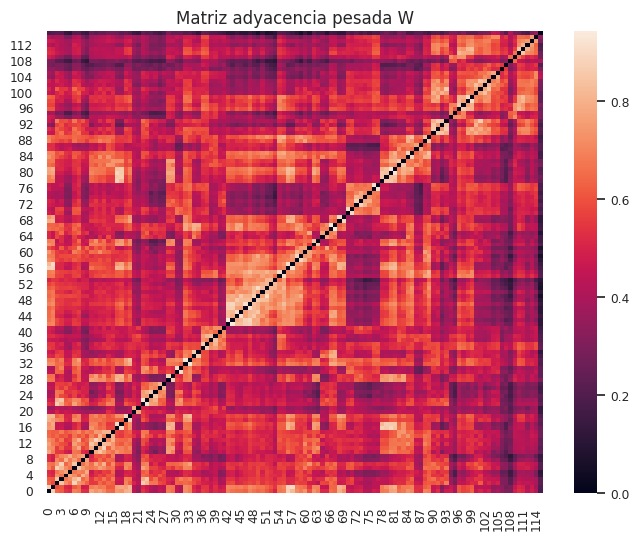

In [ ]:
#Calcula las matrices de ayacencia promedio de cada estadio
ady_w = promediar_matrices(filenames_w)
visualizar_matriz(ady_w, "W")


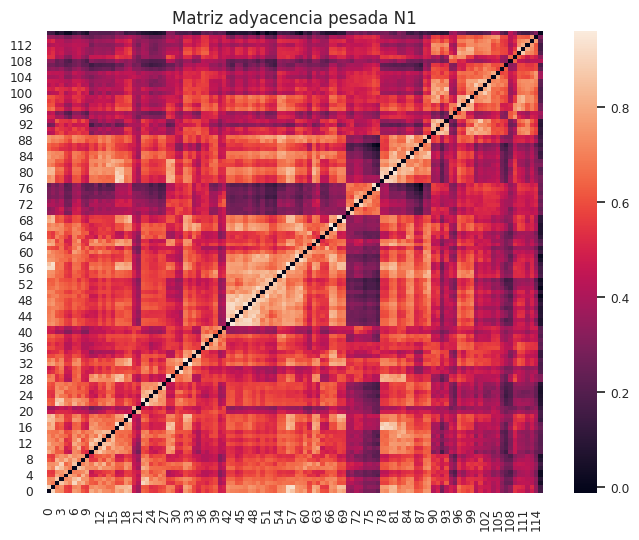

In [ ]:
ady_n1 = promediar_matrices(filenames_n1)
visualizar_matriz(ady_n1, "N1")



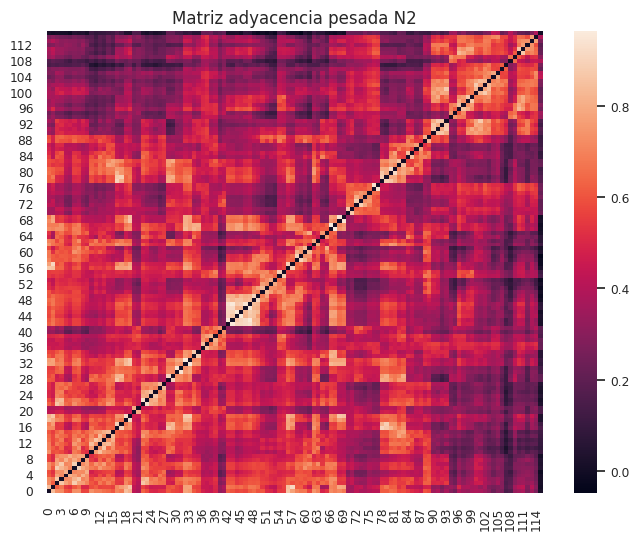

In [ ]:
ady_n2 = promediar_matrices(filenames_n2)
visualizar_matriz(ady_n2, "N2")


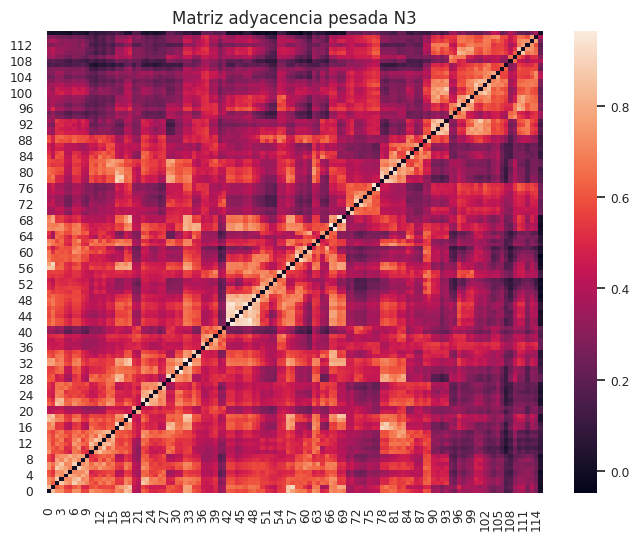

In [ ]:
ady_n3 = promediar_matrices(filenames_n3)
visualizar_matriz(ady_n2, "N3")


## Tarea  1.1

### W

,Densidad,tam_componente_gigante
0,0.0250,47
1,0.0275,61
2,0.0300,64
3,0.0325,64
4,0.0350,64
5,0.0375,68
6,0.0400,70
7,0.0425,70
8,0.0450,70
9,0.0475,70


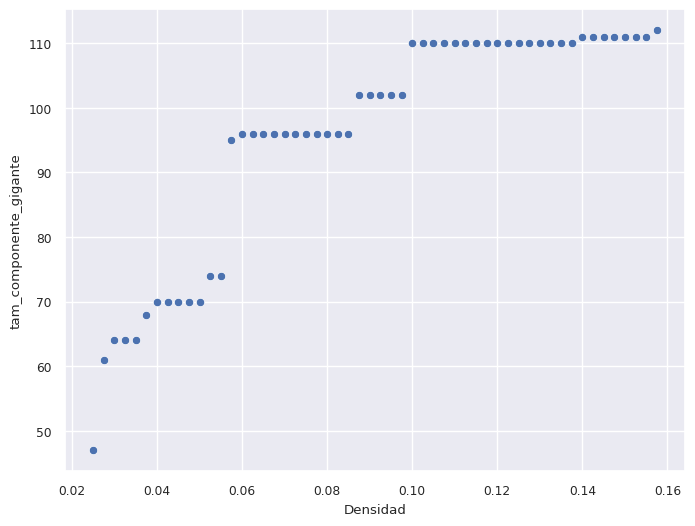

In [ ]:
densidades = np.arange(0.025, 0.16, 0.0025)


iterar_densidades(ady_w, densidades)


###N1

,Densidad,tam_componente_gigante
0,0.0250,59
1,0.0275,63
2,0.0300,65
3,0.0325,65
4,0.0350,65
5,0.0375,67
6,0.0400,70
7,0.0425,72
8,0.0450,72
9,0.0475,72


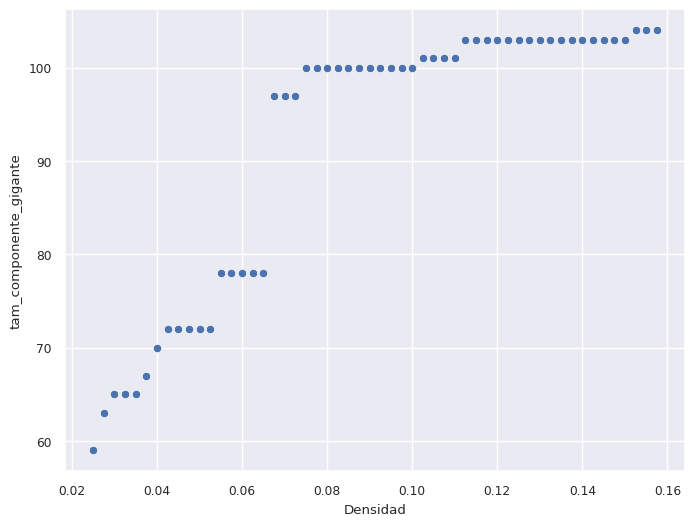

In [ ]:
iterar_densidades(ady_n1, densidades)


###N2

,Densidad,tam_componente_gigante
0,0.0250,42
1,0.0275,42
2,0.0300,60
3,0.0325,62
4,0.0350,64
5,0.0375,70
6,0.0400,70
7,0.0425,70
8,0.0450,70
9,0.0475,70


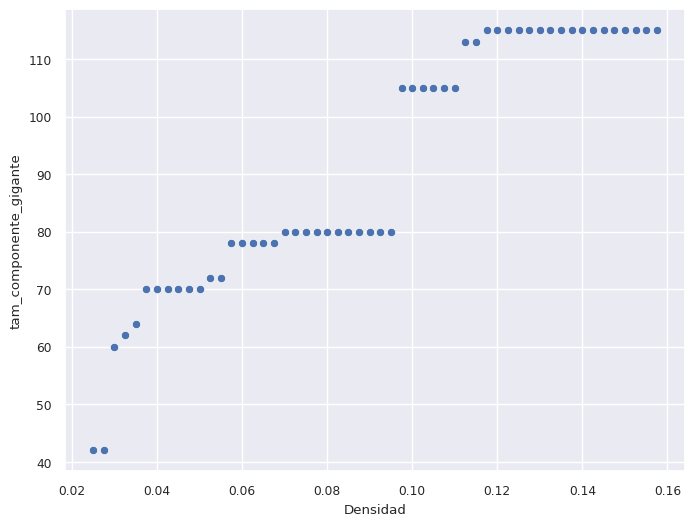

In [ ]:
iterar_densidades(ady_n2, densidades)


###N3

,Densidad,tam_componente_gigante
0,0.0250,58
1,0.0275,58
2,0.0300,66
3,0.0325,90
4,0.0350,92
5,0.0375,92
6,0.0400,94
7,0.0425,96
8,0.0450,96
9,0.0475,97


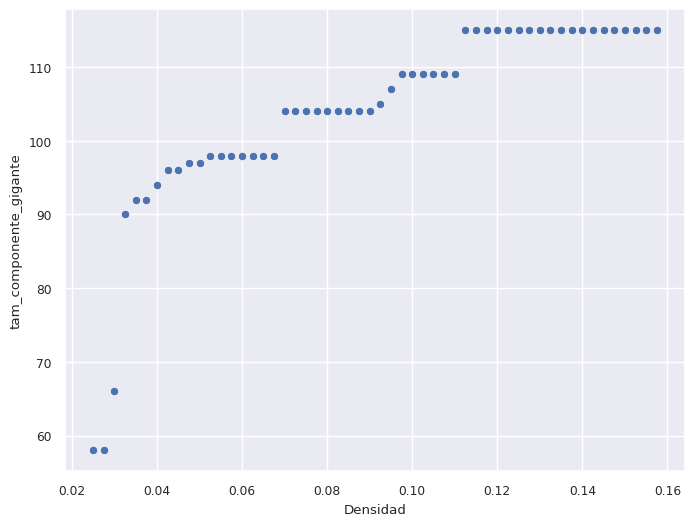

In [ ]:
iterar_densidades(ady_n3, densidades)


##Tarea 1.2

###W

<ipython-input-28-b8695c8dac91>:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


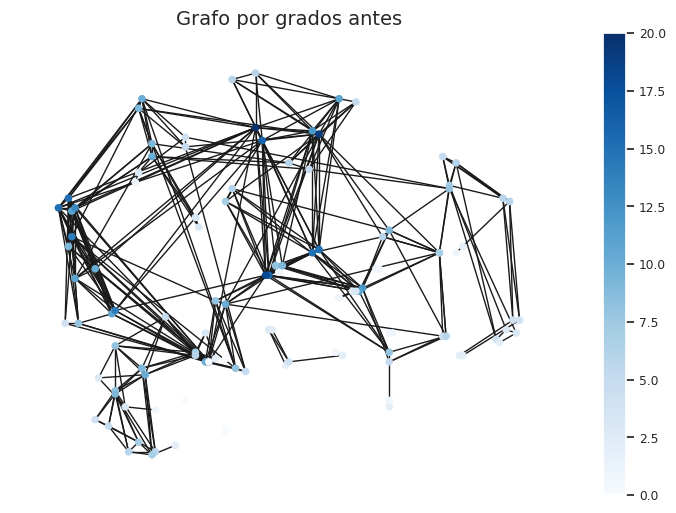

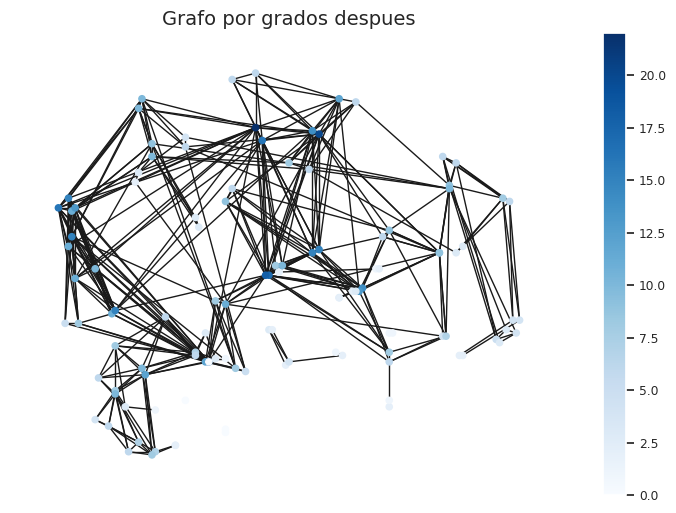

In [ ]:

G_antes = binarizar_matriz(ady_w, 0.0550)
G_despues = binarizar_matriz(ady_w, 0.0600)

graficar_grafo(G_antes, "antes")
graficar_grafo(G_despues, "despues")


###N1

<ipython-input-28-b8695c8dac91>:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


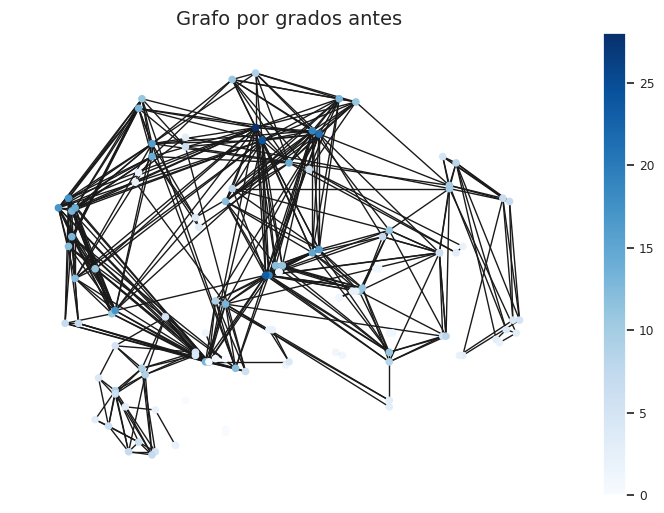

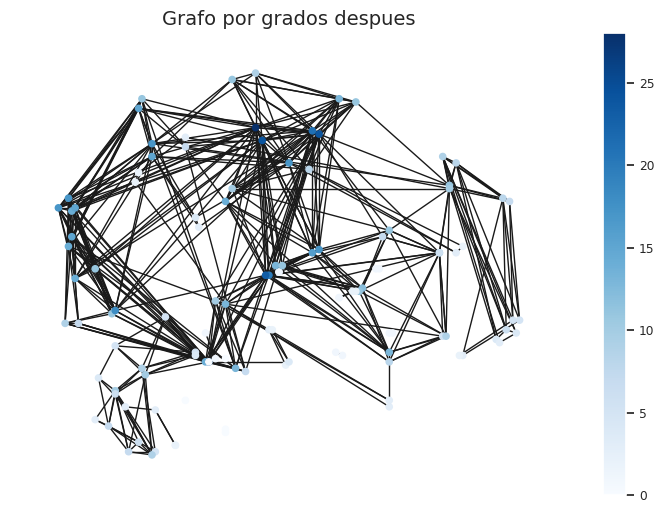

In [ ]:
G_antes = binarizar_matriz(ady_n1, 0.0650)
G_despues = binarizar_matriz(ady_n1, 0.0700)

graficar_grafo(G_antes, "antes")
graficar_grafo(G_despues, "despues")


###N2

<ipython-input-28-b8695c8dac91>:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


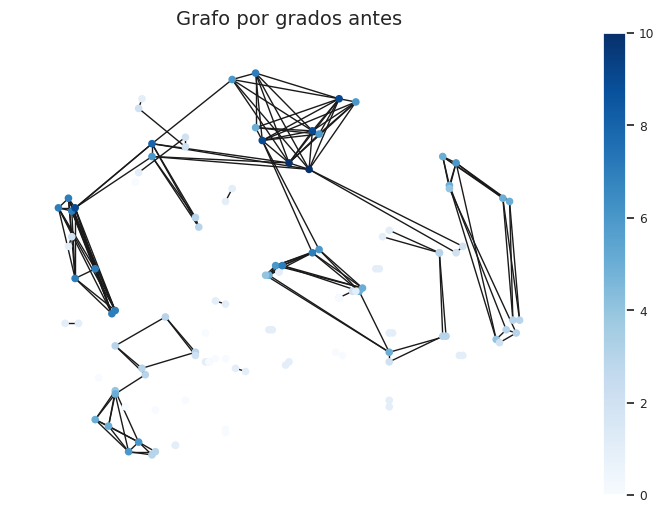

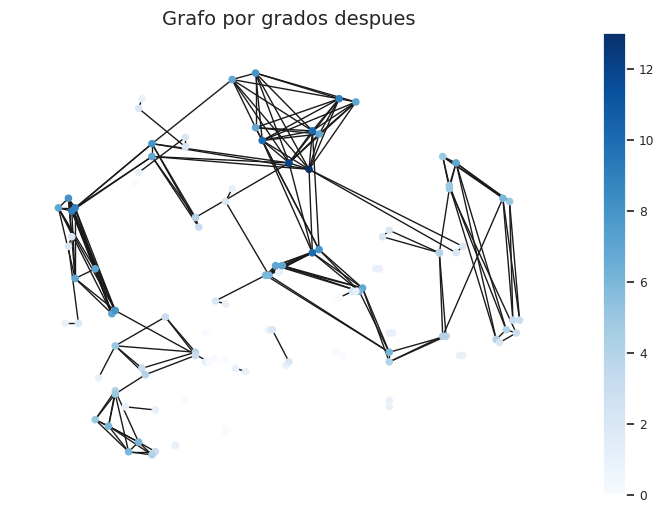

In [ ]:

G_antes = binarizar_matriz(ady_n2, 0.0275)
G_despues = binarizar_matriz(ady_n2, 0.0320)

graficar_grafo(G_antes, "antes")
graficar_grafo(G_despues, "despues")


###N3

<ipython-input-28-b8695c8dac91>:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


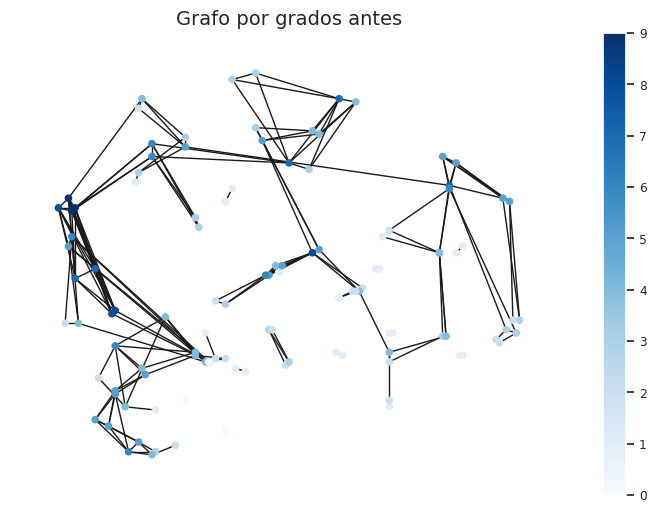

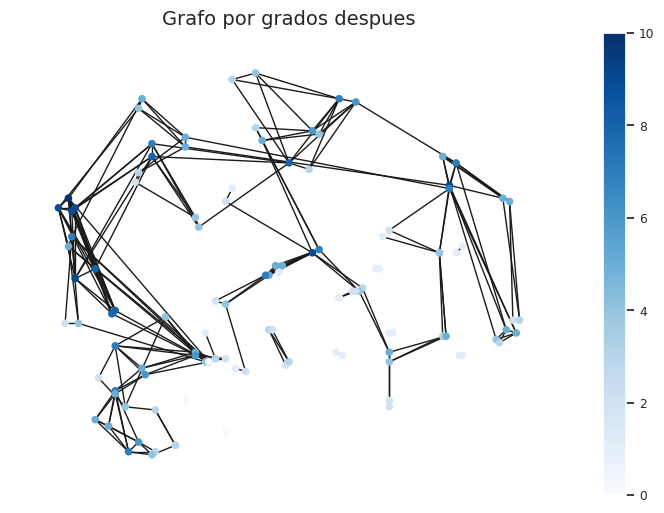

In [ ]:
G_antes = binarizar_matriz(ady_n3, 0.0300)
G_despues = binarizar_matriz(ady_n3, 0.0350)

graficar_grafo(G_antes, "antes")
graficar_grafo(G_despues, "despues")


## Tarea 1.3

### Grado Medio


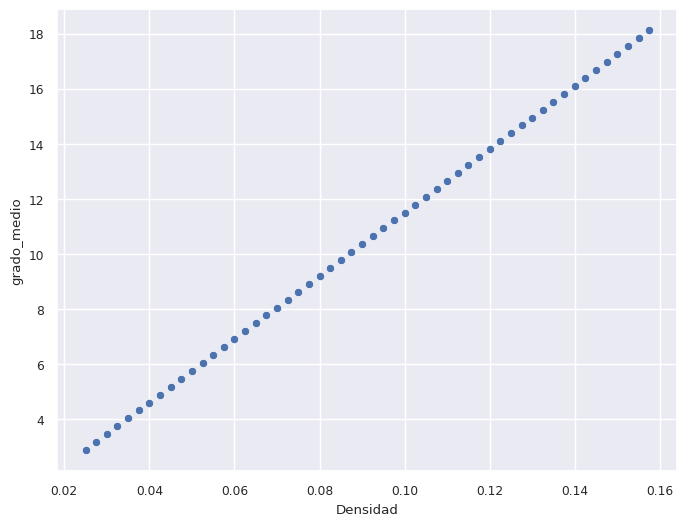

In [ ]:
df = iterar_densidades_grado_medio(ady_w, densidades)

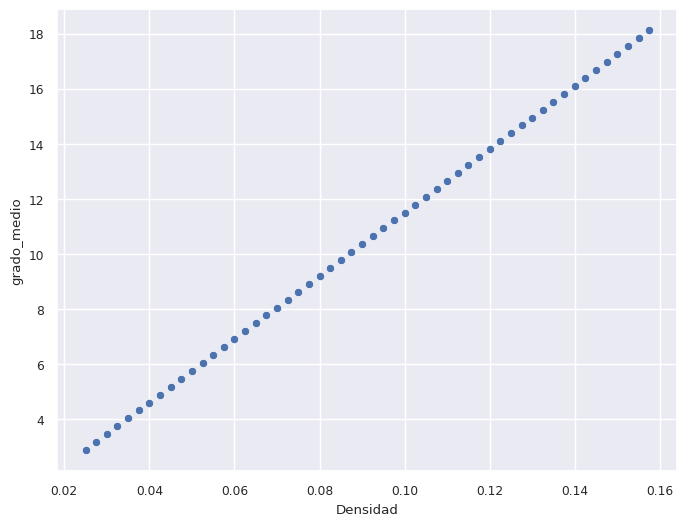

In [ ]:
df = iterar_densidades_grado_medio(ady_n1, densidades)

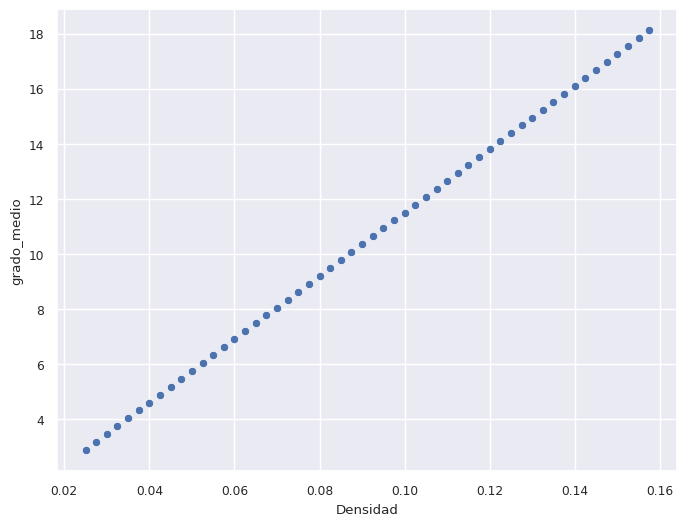

In [ ]:
df = iterar_densidades_grado_medio(ady_n2, densidades)

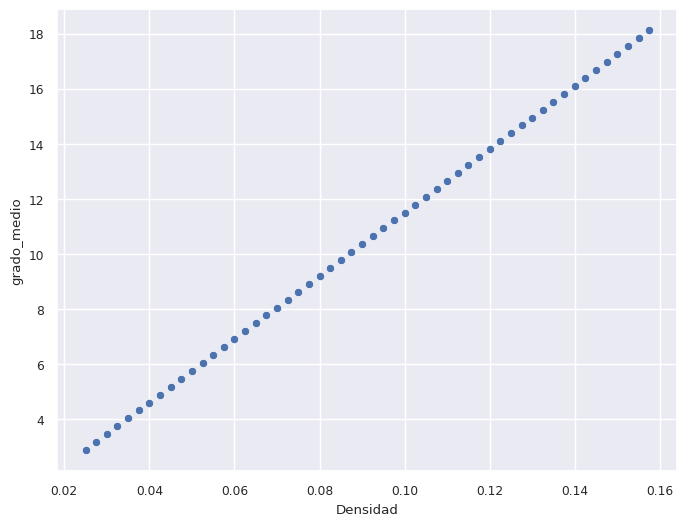

In [ ]:
df = iterar_densidades_grado_medio(ady_n3, densidades)

### Coeficiente clustering

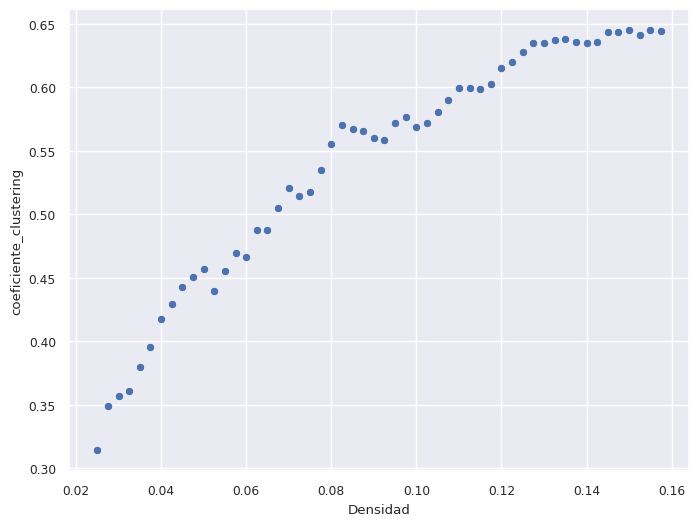

In [ ]:
df = iterar_densidades_coef_clustering(ady_w, densidades)


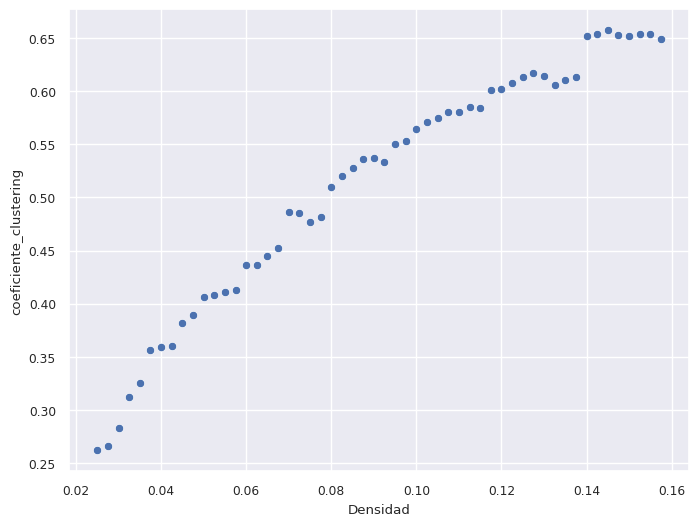

In [ ]:
df = iterar_densidades_coef_clustering(ady_n1, densidades)


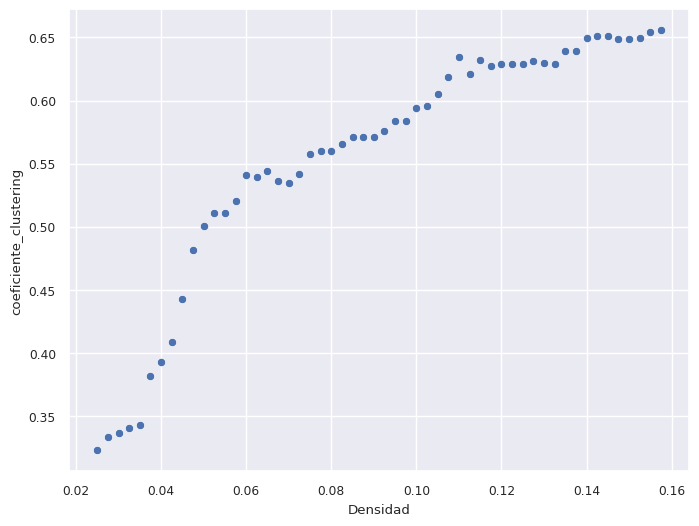

In [ ]:
df = iterar_densidades_coef_clustering(ady_n2, densidades)


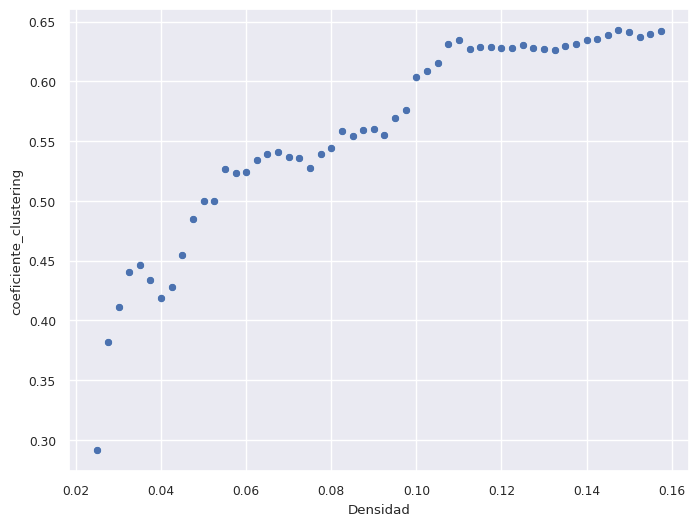

In [ ]:
df = iterar_densidades_coef_clustering(ady_n3, densidades)


### Eficiencia Global

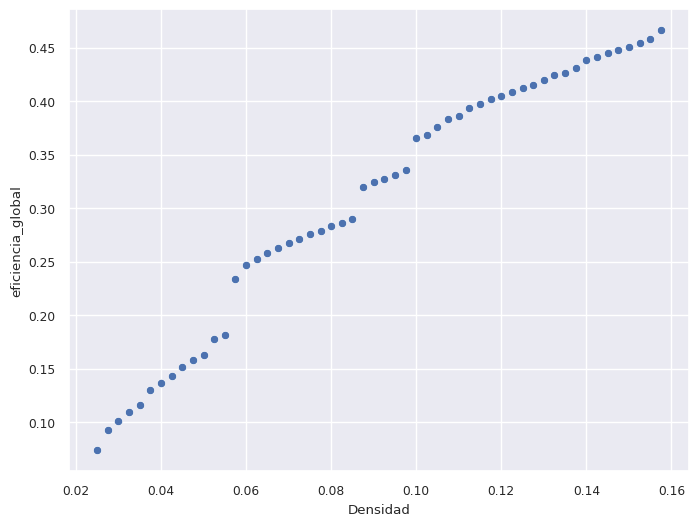

In [ ]:
df = iterar_densidades_eficiencia_global(ady_w, densidades)


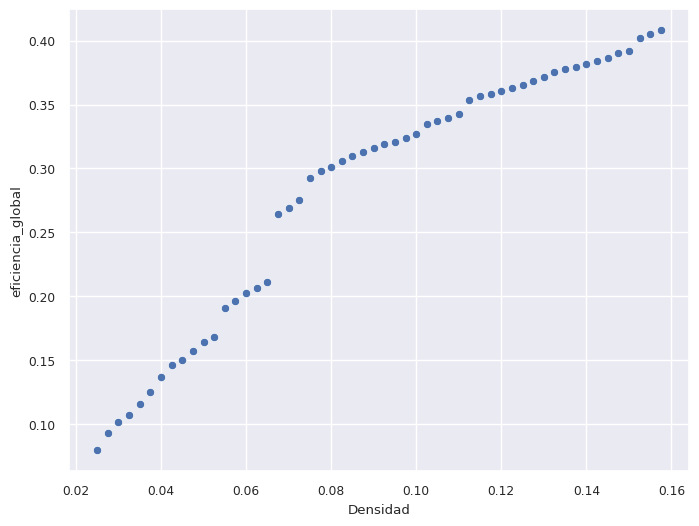

In [ ]:
df = iterar_densidades_eficiencia_global(ady_n1, densidades)


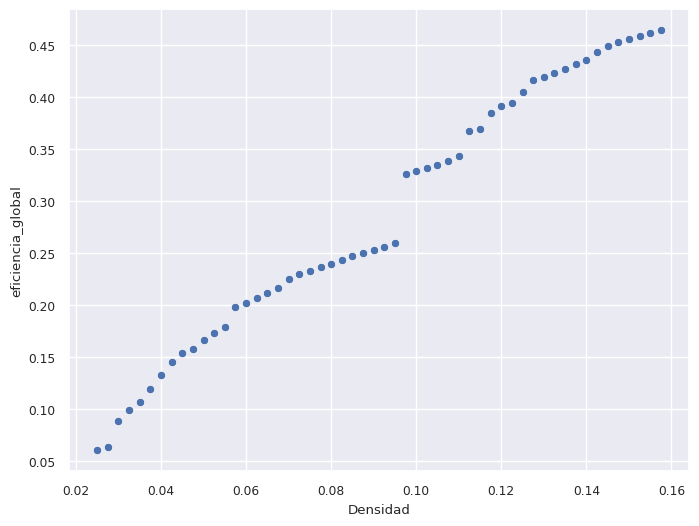

In [ ]:
df = iterar_densidades_eficiencia_global(ady_n2, densidades)


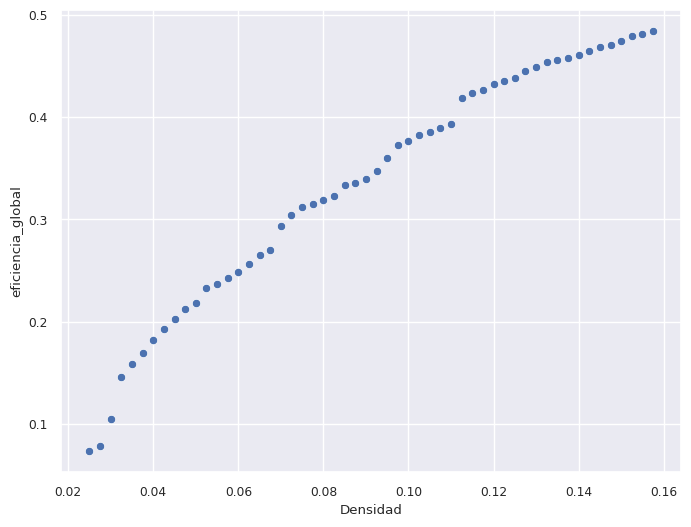

In [ ]:
df = iterar_densidades_eficiencia_global(ady_n3, densidades)


## Tarea 1.4

Centralidad de Autovector: {0: 0.2406658992150284, 1: 0.24119363860005116, 2: 0.01352704997365299, 3: 0.030472194673344683, 4: 0.0058994214054491415, 5: 0.009057435543611814, 6: 0.06778348235129383, 7: 0.07613300395210873, 8: 0.004635405238618508, 9: 0.010845228136724967, 10: 0.11123723975224571, 11: 0.11160218622104692, 12: 0.09862874529155574, 13: 0.10544359054023197, 14: 0.04555465919725834, 15: 0.056627072107411185, 16: 0.12715482409123238, 17: 0.1323517821665559, 18: 0.07757443107775179, 19: 0.13406476153187805, 20: 3.9276317179857396e-22, 21: 3.9276317179857396e-22, 22: 0.014707943583568549, 23: 0.012501486417574294, 24: 0.00196914840140555, 25: 0.0042060458893521165, 26: 0.00027934066322558425, 27: 0.00027934066322558425, 28: 0.12869215935911144, 29: 0.11563384418222827, 30: 0.012795263332430463, 31: 0.01065850946976881, 32: 0.15561056103551277, 33: 0.09547802805198154, 34: 0.0203524656211647, 35: 0.02295974353093427, 36: 0.001922721834801267, 37: 0.0007986697736441946, 38: 0.00

<ipython-input-28-b8695c8dac91>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
<ipython-input-28-b8695c8dac91>:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


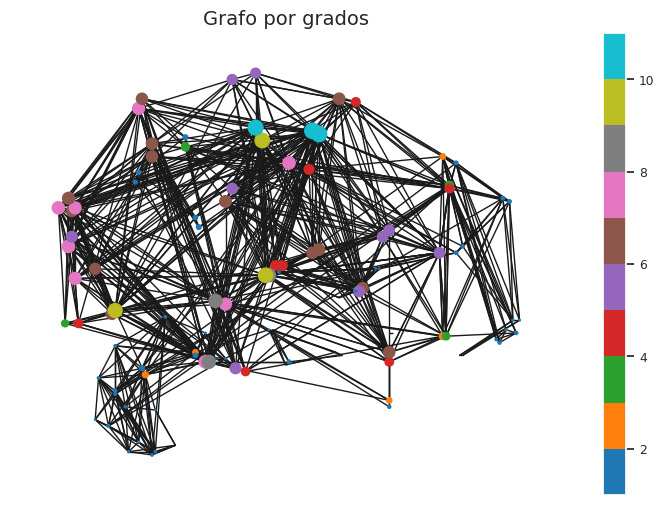

In [ ]:


G = binarizar_matriz(ady_w, 0.12)
graficar_grafo_por_centralidad(G, titulo = "", alfa = 5)


Centralidad de Autovector: {0: 0.23285400380677812, 1: 0.2393034928980469, 2: 0.0687272837899857, 3: 0.08865518419490107, 4: 0.013317897440375452, 5: 0.009262885298769006, 6: 0.09416245851225316, 7: 0.0783717629231839, 8: 0.017290610827424842, 9: 0.012645675706188462, 10: 0.09678258566746872, 11: 0.09261943395419485, 12: 0.10341066842781364, 13: 0.07834408618791427, 14: 0.08450796068230863, 15: 0.06342574816550188, 16: 0.13373745139912235, 17: 0.1304247931700486, 18: 0.12722387704822344, 19: 0.1300506367862353, 20: 3.447733412462798e-20, 21: 3.447733412462798e-20, 22: 0.020476484994677115, 23: 0.01988869036789559, 24: 0.005307394641497368, 25: 0.008881114266219632, 26: 0.0058442506475576755, 27: 0.0025369730785297327, 28: 0.09457517548894631, 29: 0.0828560529918744, 30: 0.009753241772056557, 31: 0.010554975659573307, 32: 0.129431601153259, 33: 0.09221380562981328, 34: 0.023937860461877198, 35: 0.023937860461877198, 36: 0.0006380961460415541, 37: 0.0006381398400013912, 38: 0.00061237356

<ipython-input-28-b8695c8dac91>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
<ipython-input-28-b8695c8dac91>:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


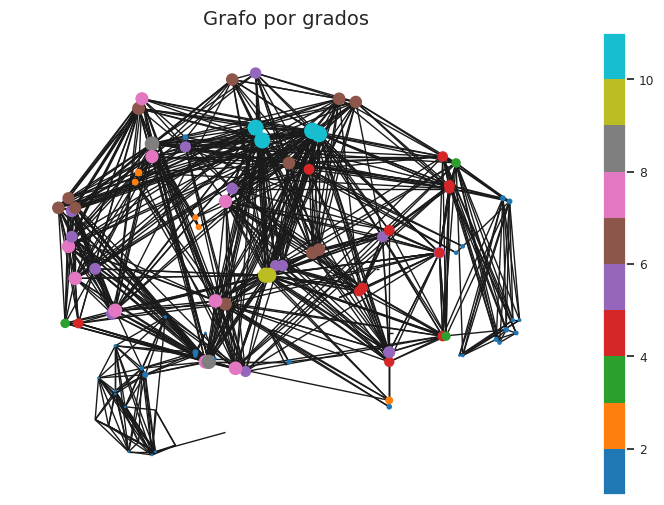

In [ ]:
G = binarizar_matriz(ady_n1, 0.12)
graficar_grafo_por_centralidad(G, titulo = "", alfa = 5)


Centralidad de Autovector: {0: 0.20144202652799303, 1: 0.1828020943431815, 2: 0.1513201619173344, 3: 0.17184838286300153, 4: 0.04960912077974472, 5: 0.04550477380339674, 6: 0.1435968384242478, 7: 0.16186783503225072, 8: 0.0522626521299452, 9: 0.04613151392425028, 10: 0.08912825799744507, 11: 0.07865558982720651, 12: 0.10652995557319281, 13: 0.08934398655431151, 14: 0.13277355901004767, 15: 0.10935654173603465, 16: 0.1677862006105729, 17: 0.16395992163818227, 18: 0.20709891831738694, 19: 0.20233260932320207, 20: 0.004988409843487966, 21: 0.00022209409814739344, 22: 0.12370456869564503, 23: 0.07997907987263907, 24: 0.042679215296166376, 25: 0.043315453983832, 26: 0.03726420478440265, 27: 0.041750547207613675, 28: 0.12663079065004554, 29: 0.11960625453629896, 30: 0.11182199723110581, 31: 0.1031722630542086, 32: 0.23946585498565845, 33: 0.22610591622933127, 34: 0.06482866410248027, 35: 0.04694864142569586, 36: 0.00034170309804083766, 37: 0.00035136251745119276, 38: 0.0009790163899463847, 3

<ipython-input-28-b8695c8dac91>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
<ipython-input-28-b8695c8dac91>:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


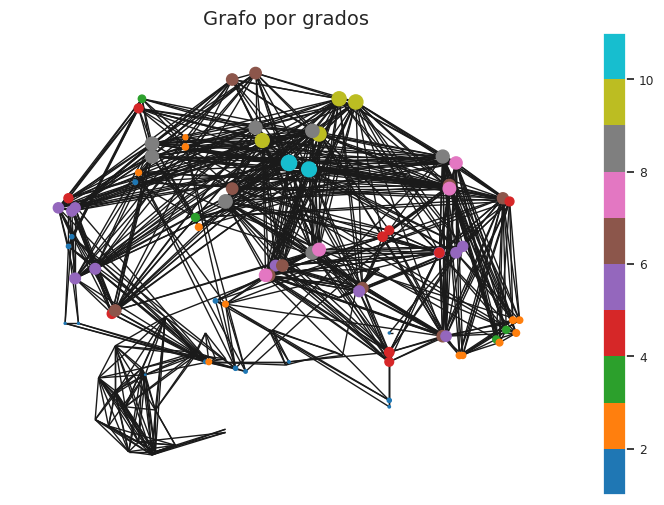

In [ ]:
G = binarizar_matriz(ady_n2, 0.12)
graficar_grafo_por_centralidad(G, titulo = "", alfa = 5)


Centralidad de Autovector: {0: 0.16125463463723275, 1: 0.09206522448598009, 2: 0.23239905800156893, 3: 0.23316993021586482, 4: 0.13785344474928993, 5: 0.11197008061795471, 6: 0.2310601674955297, 7: 0.23239433158932585, 8: 0.14927305673960714, 9: 0.14359624346202515, 10: 0.08040177994823493, 11: 0.1201211220578252, 12: 0.15915022218220368, 13: 0.1743928186949641, 14: 0.149923997273896, 15: 0.15066159022590017, 16: 0.08554809014933196, 17: 0.07968906095321117, 18: 0.12451100159490272, 19: 0.08851095912816051, 20: 0.0008047453921553943, 21: 0.0007205750945278562, 22: 0.12881085137782397, 23: 0.1465765902295878, 24: 0.053031254815953735, 25: 0.03207266873632211, 26: 0.063075542810667, 27: 0.08082563870047363, 28: 0.04303412280424195, 29: 0.08976343746252087, 30: 0.027664766140524717, 31: 0.03456204899717067, 32: 0.15474810352371554, 33: 0.1523595240532801, 34: 0.06387580970552183, 35: 0.0538098808344046, 36: 0.0008978027976193461, 37: 0.0008978027976193461, 38: 0.0025981990660484612, 39: 0

<ipython-input-28-b8695c8dac91>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
<ipython-input-28-b8695c8dac91>:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


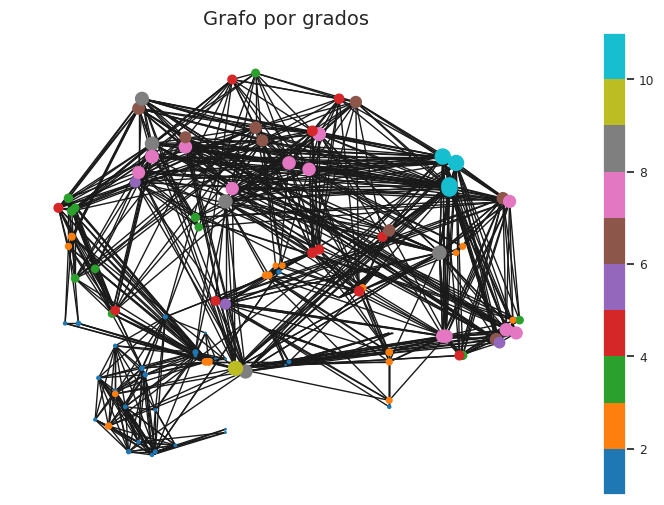

In [ ]:
G = binarizar_matriz(ady_n3, 0.12)
graficar_grafo_por_centralidad(G, titulo = "", alfa = 5)


## #Tarea 2: Comunidades y coeficiente de modularidad

## Tarea 2.1

Para cada sujeto de cada estadío generar grafos variando δ, determinar comunidades en dichos grafos a partir de algoritmo de Louvain [Blondel et al., 2008], y calcular la curva que describa el coeficiente de modularidad (Q) en función de δ. Promediando entre sujetos de cada estadío, obtener la curva correspondiente a cada estadío. Compararlas con las curvas de Q en función de δ para “modelos nulos” equivalentes: usando grafos random de igual cantidad total de nodos e igual densidad de enlaces δ. Para cada valor 2 de δ incluir un test de significancia clásico para diferencias entre el grafo observado y el modelo nulo de grafo azar (marcar con un asterico las comparciones significativas).
Discutir los resultados

In [ ]:

###----- Codigo de prueba, se puede borrar al final -----###
#import community  # Este módulo es parte de python-louvain


# Aplica el algoritmo de Louvain para detectar comunidades
partition = community.best_partition(G)

# Imprime las comunidades
print("Comunidades:", partition)

# Calcular la modularidad de la partición
modularity = community.modularity(partition, G)
print("Modularidad de la partición:", modularity)


Comunidades: {0: 0, 1: 6, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 3, 16: 3, 17: 3, 18: 6, 19: 6, 20: 4, 21: 4, 22: 5, 23: 5, 24: 5, 25: 5, 26: 5, 27: 5, 28: 3, 29: 3, 30: 5, 31: 5, 32: 6, 33: 6, 34: 5, 35: 5, 36: 4, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 6, 43: 6, 44: 6, 45: 6, 46: 6, 47: 6, 48: 6, 49: 6, 50: 6, 51: 6, 52: 6, 53: 6, 54: 6, 55: 6, 56: 6, 57: 6, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 5, 65: 0, 66: 6, 67: 6, 68: 6, 69: 6, 70: 7, 71: 7, 72: 7, 73: 7, 74: 7, 75: 7, 76: 1, 77: 1, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 3, 84: 3, 85: 3, 86: 3, 87: 3, 88: 0, 89: 0, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 2}
Modularidad de la partición: 0.4904013553594835


In [ ]:
###----- Codigo de prueba, se puede borrar al final -----###

# Imprime las comunidades de manera más legible
for node, community_id in partition.items():
    print(f"Nodo {node} pertenece a la comunidad {community_id}")

Nodo 0 pertenece a la comunidad 0
Nodo 1 pertenece a la comunidad 6
Nodo 2 pertenece a la comunidad 0
Nodo 3 pertenece a la comunidad 0
Nodo 4 pertenece a la comunidad 0
Nodo 5 pertenece a la comunidad 0
Nodo 6 pertenece a la comunidad 0
Nodo 7 pertenece a la comunidad 0
Nodo 8 pertenece a la comunidad 0
Nodo 9 pertenece a la comunidad 0
Nodo 10 pertenece a la comunidad 0
Nodo 11 pertenece a la comunidad 0
Nodo 12 pertenece a la comunidad 0
Nodo 13 pertenece a la comunidad 0
Nodo 14 pertenece a la comunidad 0
Nodo 15 pertenece a la comunidad 3
Nodo 16 pertenece a la comunidad 3
Nodo 17 pertenece a la comunidad 3
Nodo 18 pertenece a la comunidad 6
Nodo 19 pertenece a la comunidad 6
Nodo 20 pertenece a la comunidad 4
Nodo 21 pertenece a la comunidad 4
Nodo 22 pertenece a la comunidad 5
Nodo 23 pertenece a la comunidad 5
Nodo 24 pertenece a la comunidad 5
Nodo 25 pertenece a la comunidad 5
Nodo 26 pertenece a la comunidad 5
Nodo 27 pertenece a la comunidad 5
Nodo 28 pertenece a la comunid

In [ ]:
from scipy.stats import sem
from scipy.stats import ttest_ind, wilcoxon

def calcular_modularidad(m_ady, d):

    #Matriz W
    G = binarizar_matriz(m_ady, d)
    partition = community.best_partition(G)
    modularity = community.modularity(partition, G)
    return G, modularity


def generar_grafos_random(repetitions, nodos, ejes):

  modularity_random = 0
  modularidades_random = []

  for i in range(repetitions):
    G_random = nx.gnm_random_graph(nodos,ejes)
    partition_random = community.best_partition(G_random)

    modularidad = community.modularity(partition_random, G_random)
    modularity_random = modularity_random + modularidad / repetitions
    modularidades_random.append(modularidad)


  return G_random, modularity_random, modularidades_random

def calcular_significancia(m, modularidades_random):

  t_stat, p_valor_t = ttest_ind(m, modularidades_random)

  return t_stat, p_valor_t

def iterar_densidades_modularidad(m_ady, m_ady_n, densidades, titulo_1 = "", titulo_2 = ""):

  modularidades = []

  for d in densidades:
    #Matriz W
    G, modularity = calcular_modularidad(m_ady, d)

    #Matriz N X
    G_n, modularity_n = calcular_modularidad(m_ady_n, d)

    #Matriz Random
    G_random, modularity_random, modularidades_random = generar_grafos_random (30, G_n.number_of_nodes(),G_n.number_of_edges() )

    modularidades.append((d, modularity, modularity_n, modularity_random))

    t_stat, p_valor_t = calcular_significancia(modularity, modularidades_random)

    if p_valor_t < 0.05:
      plt.text(d, 0.15, '*', color = 'black', fontsize = 10)  # 's' controla el tamaño del marcador


  df_resultados = pd.DataFrame(modularidades, columns=['Densidad', 'Modularidad', 'Modularidad_N', 'Modularidad_Random'])

  sns.lineplot(x='Densidad', y='Modularidad', data=df_resultados, label= f'Modularidad {titulo_1}', marker='o', color='blue')
  sns.lineplot(x='Densidad', y='Modularidad_N', data=df_resultados, label= f'Modularidad {titulo_2}', marker='o', color='red')
  sns.lineplot(x='Densidad', y='Modularidad_Random', data=df_resultados, label= f'Modularidad Random', marker='o', color='black')


  sd_w = df_resultados['Modularidad'].std()

  print(sd_w)
  media_modularidad = np.mean(df_resultados['Modularidad'])
  sem_modularidad = sem(df_resultados['Modularidad'])
  sem_modularidad_n = sem(df_resultados['Modularidad_N'])
  sem_modularidad_randon = sem(df_resultados['Modularidad_Random'])

  # Imprimir los resultados
  print(f'Mean ± SEM modularity: {media_modularidad:.2f} ± {sem_modularidad:.2f}')

  plt.errorbar(df_resultados['Densidad'], df_resultados['Modularidad'], yerr = sem_modularidad ,  fmt='-s', color='blue')
  plt.errorbar(df_resultados['Densidad'], df_resultados['Modularidad_N'], yerr = sem_modularidad_n ,  fmt='o', color='red')
  plt.errorbar(df_resultados['Densidad'], df_resultados['Modularidad_Random'], yerr = sem_modularidad_n ,  fmt='o', color='black')

  return(df_resultados)

In [ ]:

#Modularidades de sujetos en estadio W
modularidades = []

l = len(filenames_w)
for filename in filenames_w:
  m = calcular_matriz(filename)
  for d in densidades:
      G, modularity = calcular_modularidad(m, d)

      modularidades.append((filename, 'W', d, modularity,G.number_of_nodes(), G.number_of_edges() ))

df_modularidades = pd.DataFrame(modularidades, columns=['filename', 'estadio', 'densidad', 'modularidad', 'nodos', 'ejes'])
df_modularidades

,filename,estadio,densidad,modularidad,nodos,ejes
0,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0250,0.743447,116,167
1,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.741405,116,184
2,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0300,0.718497,116,201
3,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0325,0.714647,116,217
4,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0350,0.680382,116,234
...,...,...,...,...,...,...
967,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.1475,0.344420,116,984
968,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.1500,0.351898,116,1001
969,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.1525,0.351951,116,1018
970,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.1550,0.349789,116,1034


In [ ]:
#df_modularidades.loc[df_modularidades['densidad']==0.0275]
promedio_modularidad_random = df_modularidades_random.groupby('densidad')['modularidad_random'].mean().reset_index()


,filename,estadio,densidad,modularidad,nodos,ejes
1,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.741405,116,184
55,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.670546,116,184
109,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.670915,116,184
163,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.437884,116,184
217,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.749675,116,184
271,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.698429,116,184
325,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.616863,116,184
379,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.672228,116,185
433,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.640300,116,184
487,/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/...,W,0.0275,0.772832,116,184


In [ ]:
#sns.lineplot(x='densidad', y='modularidad', data = df_modularidades, label = f'Modularidad W_suj1', marker='o', color='blue')
nodos, ejes = G.number_of_nodes(), G.number_of_edges()
modularidades_random = []
for d in densidades:
  G_random, modularity_random, modularidades_random = generar_grafos_random (30, nodos, ejes )
  modularidades_random.append(('random', d, modularity_random))


modu_random = []
for d in densidades:
  G_random, modularity_random, modularidades_random = generar_grafos_random (30, nodos, ejes )
  modu_random.append(('random', d, modularity_random))


modu_random

[('random', 0.025, 0.1791402506425397),
 ('random', 0.0275, 0.17923591112688353),
 ('random', 0.03, 0.18018009821344239),
 ('random', 0.0325, 0.17985770427511838),
 ('random', 0.034999999999999996, 0.18005074532191565),
 ('random', 0.03749999999999999, 0.17919182280902032),
 ('random', 0.039999999999999994, 0.1804932580482304),
 ('random', 0.042499999999999996, 0.17826741662072249),
 ('random', 0.04499999999999999, 0.18139364349661105),
 ('random', 0.04749999999999999, 0.179097203424585),
 ('random', 0.04999999999999999, 0.1785416936371896),
 ('random', 0.05249999999999999, 0.1781493800325487),
 ('random', 0.054999999999999986, 0.17811737752666643),
 ('random', 0.05749999999999999, 0.1779974699763384),
 ('random', 0.059999999999999984, 0.17911505300707373),
 ('random', 0.06249999999999998, 0.17800035186159224),
 ('random', 0.06499999999999997, 0.180908611646498),
 ('random', 0.06749999999999998, 0.17942436529872174),
 ('random', 0.06999999999999998, 0.1789353501098285),
 ('random', 0.0

<ErrorbarContainer object of 3 artists>

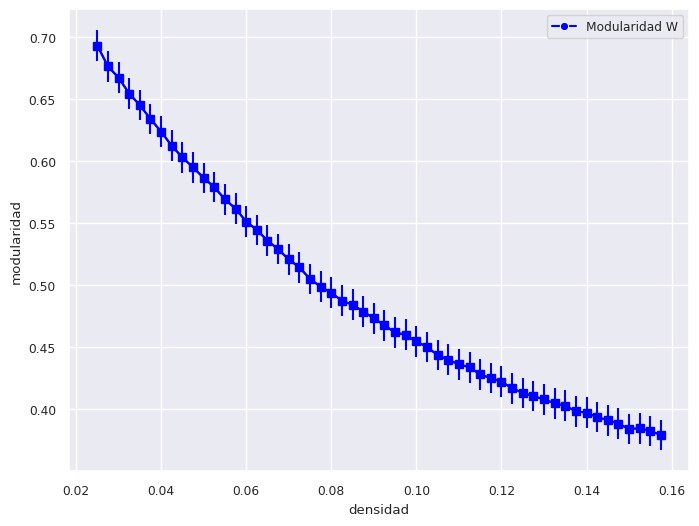

In [ ]:
#df_modularidades_random = pd.DataFrame(modu_random, columns=['estadio', 'densidad', 'modularidad_random'])

#promedio_modularidad_random = df_modularidades_random.groupby('densidad')['modularidad_random'].mean().reset_index()
#promedio_modularidad
#sem_modularidad_random = sem(promedio_modularidad_random['modularidad_random'])

#sns.lineplot(x='densidad', y='modularidad_random', data=df_modularidades_random, label= f'Modularidad Random', marker='o', color='black')

promedio_modularidad = df_modularidades.groupby('densidad')['modularidad'].mean().reset_index()
sem_modularidad = sem(promedio_modularidad['modularidad'])
sns.lineplot(x='densidad', y='modularidad', data = promedio_modularidad, label = 'Modularidad W', marker='o', color='blue')
plt.errorbar(promedio_modularidad['densidad'], promedio_modularidad['modularidad'], yerr = sem_modularidad ,  fmt='-s', color='blue')


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs
0.09583863091249907
Mean ± SEM modularity: 0.56 ± 0.01


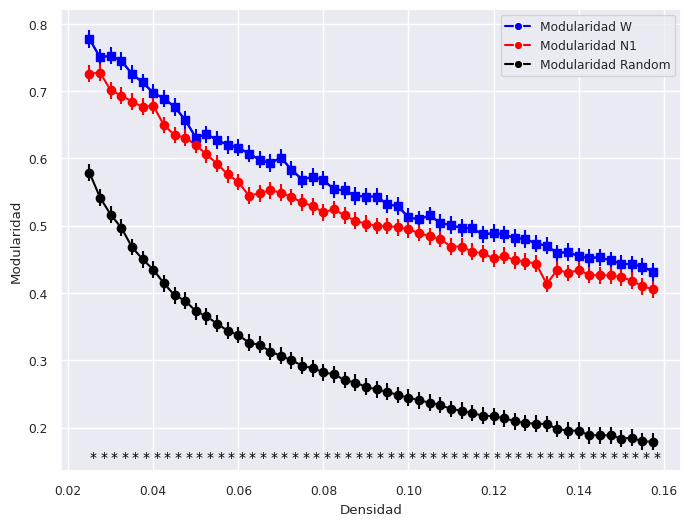

In [ ]:
#Item 2
%time

ady_w = promediar_matrices(filenames_w)
ady_n1 = promediar_matrices(filenames_n1)

a = iterar_densidades_modularidad(ady_w, ady_n1, densidades, "W", "N1")


0.09559799302846667
Mean ± SEM modularity: 0.56 ± 0.01


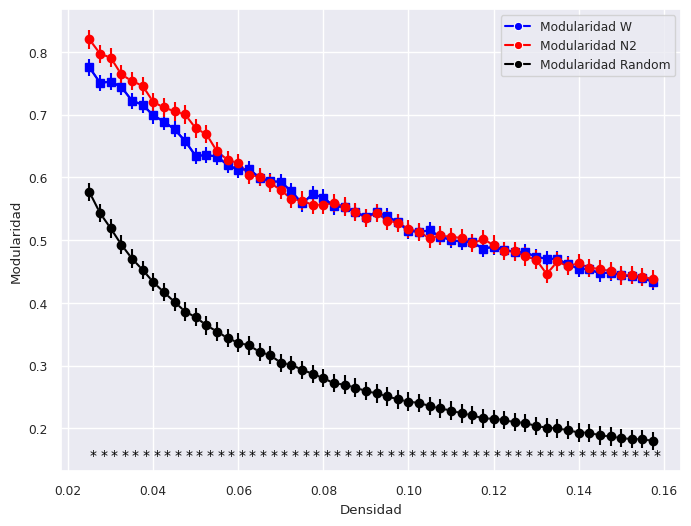

In [ ]:
#Item 2
ady_w = promediar_matrices(filenames_w)
ady_n2 = promediar_matrices(filenames_n2)

a = iterar_densidades_modularidad(ady_w, ady_n2, densidades, "W", "N2")


0.09559792715737629
Mean ± SEM modularity: 0.56 ± 0.01


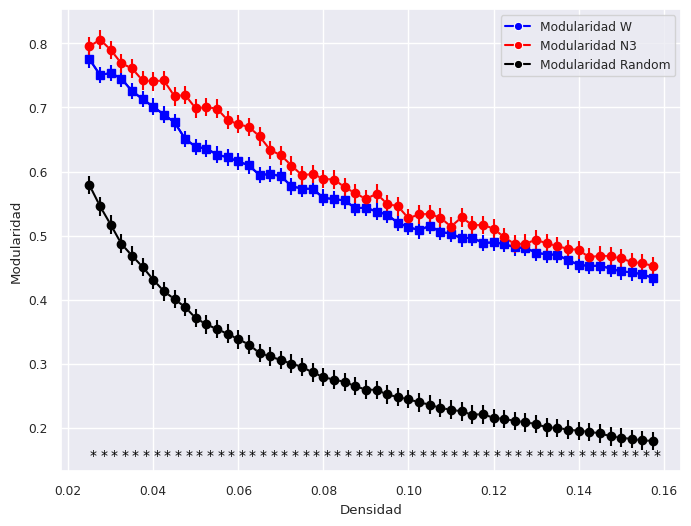

In [ ]:
#Item 2
ady_w = promediar_matrices(filenames_w)
ady_n3 = promediar_matrices(filenames_n3)

a = iterar_densidades_modularidad(ady_w, ady_n3, densidades, "W", "N3")



In [ ]:
#Item 3

G_n3 = binarizar_matriz(ady_n3, 0.012)

G = nx.gnm_random_graph(G_n3.number_of_nodes(),G_n3.number_of_edges())
G.number_of_nodes()

print (f'Grafo G_n3 tiene {G_n3.number_of_nodes()} nodos, {G_n3.number_of_edges()} ejes y {nx.density(G_n3)} de densidad')
print (f'Grafo G tiene {G.number_of_nodes()} nodos, {G.number_of_edges()} ejes y {nx.density(G)} de densidad')





## Tarea 2.2

## Tarea 2.3

## Tarea 2.4

## Tarea 2.5 (Opcional 1)

## Tarea 2.6 (Opcional 2)



# Tarea 3: Diferencias en las comunidades para los diferentes estadíos


## Tarea 3.1

## Tarea 3.2


## Tarea 3.3

## Tarea 3.4

## tarea 3.5

# Opcional 3: Rol de nodos, y cambios en el rol de los nodos

# A partir de aca lo del pretp...
lo deje para tomar los ejemplos que necesitemos

#Item 5: Manipulación de datos

## Ejemplo: Analizar el sujeto 1 de la condición W
Levantamos los datos y los transformamos en una matriz de adyacencia pesada

### Matriz de adyacencia pesada

In [ ]:
filename = dataset_path + 'DataSujetos/W_suj1.csv'
df = pd.read_csv(filename, header=None)

matAdyacPesada = df.values
n = matAdyacPesada.shape[0]
matAdyacPesada -= np.diag(np.ones(n))

Graficamos la matriz de ayacencia pesada

In [ ]:
sns.heatmap(matAdyacPesada)
plt.xlim(0,n)
plt.ylim(0,n)

### Matriz binarizada

Le ponemos un umbral "th" para binarizarla hacia una matriz de adyacencia no pesada:

In [ ]:
th = 0.65
matAdyacNoPesada = matAdyacPesada >= th
sns.heatmap(matAdyacNoPesada)
plt.xlim(0,n)
plt.ylim(0,n)

### Creamos un grafo con la librería Networkx

*   List item
*   List item



In [ ]:
G = nx.from_numpy_array(matAdyacNoPesada)

### Visualizaciones
Graficamos al grafo con los nodos dispuestos de diferentes formas

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Sin especificar posiciones', fontsize=14)
nx.draw(G, with_labels=True, font_weight='bold')

plt.figure(figsize=(8,6))
plt.title('Con nodos a lo largo de un círculo', fontsize=14)
layout=nx.circular_layout(G)
nx.draw(G,layout, with_labels=True, font_weight='bold')


plt.figure(figsize=(8,6))
plt.title('Con nodos en sus coordenadas cerebrales', fontsize=14)
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
nx.draw(G,layout, with_labels=True, linewidths =1)








#### Graficamos el grafo con cada nodo coloreado de acuerdo a su grado (cantidad de enlances que posee)

In [ ]:
degrees = G.degree() # Diccionario con ID de nodo y su grado
nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes])
plt.figure(figsize=(9,6))
plt.title('Con nodos coloreados de acuerdo a su grado', fontsize=14)
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
vmin = min(n_color)
vmax = max(n_color)
cmap=plt.cm.Blues
nx.draw(G, layout, node_size=20, node_color=n_color, vmin=vmin, vmax=vmax,cmap=cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
plt.colorbar(sm)


Cuál es el nodo con más enlaces?

In [ ]:
sortedNodes=sorted(G.degree, key=lambda x: x[1], reverse=True)
print('El nodo con mayor grado es el',sortedNodes[0][0], ', que posee', sortedNodes[0][1], 'enlaces' )

## Ejempplo: Comparemos dos estados de vigila

In [ ]:
filename = dataset_path + 'DataSujetos/W_suj1.csv'
df = pd.read_csv(filename, header=None)
matAdyacPesadaWake = df.values
n = matAdyacPesadaWake.shape[0]
matAdyacPesadaWake -= np.diag(np.ones(n))


filename = dataset_path + 'DataSujetos/N3_suj1.csv'
df = pd.read_csv(filename, header=None)
matAdyacPesadaSleep = df.values
n = matAdyacPesadaSleep.shape[0]
matAdyacPesadaSleep -= np.diag(np.ones(n))


Como observamos ambos estados están asociados a diferentes niveles de correlación entre áreas. ¿Cómo compararlos?

In [ ]:

plt.figure(figsize=(12,4))
plt.subplot(131)
sns.heatmap(matAdyacPesadaWake,vmin=-.6,vmax=.9)
plt.xlim(0,n)
plt.ylim(0,n)
plt.title('Sujeto despierto')

plt.subplot(133)
sns.heatmap(matAdyacPesadaSleep,vmin=-.6,vmax=.9)
plt.xlim(0,n)
plt.ylim(0,n)
plt.title('Sujeto dormido')

### Función  para binarizar una matriz de adyacencia pesada

en función de a densidades de enlances resultantes

In [ ]:
densidad=0.1 # comparemos ambos estados con una densidad de enlaces de 10%

plt.figure(figsize=(6,4))

thWake = density_to_th(matAdyacPesadaWake, densidad)
sns.heatmap(matAdyacPesadaWake >= thWake)
plt.xlim(0,n)
plt.ylim(0,n);
plt.title(f'Despierto, binarizado a  {thWake}')
plt.show()

plt.figure(figsize=(6,4))
thSleep=density_to_th(matAdyacPesadaSleep, densidad)
sns.heatmap(matAdyacPesadaSleep>=thSleep)
plt.xlim(0,n)
plt.ylim(0,n);
plt.title(f'Dormido, binarizado a  {thSleep}')


### ¿Y la distribución de grados en ambos casos?

In [ ]:
plt.figure(figsize=(6,4))
Gsleep = nx.from_numpy_array(matAdyacPesadaSleep>=thSleep)
degreesSleep = [Gsleep.degree(n) for n in Gsleep.nodes()]
plt.hist(degreesSleep,bins=10,density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribucion de grados, durmiendo')


plt.figure(figsize=(6,4))
Gwake = nx.from_numpy_array(matAdyacPesadaWake>=thWake)
degreesWake = [Gwake.degree(n) for n in Gwake.nodes()]
plt.hist(degreesWake,bins=10,density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribucion de grados, despierto')

## Subitem 5.1: Matriz de adyacencia pesada
Graficar la matriz de correlaciones entre regiones (es decir, la "matriz de adyacencia pesada") para el sujeto 2 de la condición despierto ("Wake")

In [ ]:
sujeto_estudio = "W_suj2.csv"
filename = dataset_path + 'DataSujetos/' + sujeto_estudio
df = pd.read_csv(filename, header=None)

matAdyacPesada = df.values
n = matAdyacPesada.shape[0]
matAdyacPesada -= np.diag(np.ones(n))

In [ ]:
sns.set(font_scale=0.8)  # Ajusta el tamaño global de las fuentes
ax = sns.heatmap(matAdyacPesada)
ax.set_title("Matriz adyacencia pesada " + sujeto_estudio, fontsize=12)

plt.xlim(0,n)
plt.ylim(0,n)

## Subitem 5.2: Matriz de adyacencia binaria
Transformar dicha matriz de adyacencia pesada a una matriz de adyancia binaria Ai,j que represente una una densidad de enlaces δ=0.08. ¿Cuál es el valor de umbral de correlación entre pares de regiones que tuvo que utilizar?


In [ ]:
densidad = 0.08 # comparemos ambos estados con una densidad de enlaces de 10%
thWake = density_to_th(matAdyacPesada, densidad)

# miro el threshold resultante
print(thWake)

matAdyacNoPesada = matAdyacPesada >= thWake
ax = sns.heatmap(matAdyacNoPesada)
ax.set_title("Matriz adyacencia Binarizada " + sujeto_estudio, fontsize=12)

plt.xlim(0,n)
plt.ylim(0,n)

## Subitem 5.3: Grafo resultante

In [ ]:
G = nx.from_numpy_array(matAdyacNoPesada)

In [ ]:
plt.figure(figsize = (8,6))
plt.title('Grafo ' + sujeto_estudio, fontsize = 12)
layout = dict(zip(range(n), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
nx.draw(G, layout, with_labels = True, linewidths = 1)

## Subitem 5.4: distancia media

con thWake = 0.45 el grafo es conectado. Pero con el th necesario para una densidad e 0.08 no es conectado

In [ ]:
grafo_conectado = nx.is_connected(G)

if grafo_conectado:
    print("El grafo es conectado.")
else:
    print("El grafo no es conectado.")

In [ ]:

if grafo_conectado:
  average_distance = nx.average_shortest_path_length(G)
  print(f"Eficiencia global del grafo: {average_distance:.4f}")
else:
  global_efficiency = nx.global_efficiency(G)
  print(f"Eficiencia global del grafo: {global_efficiency:.4f}")




## Subitem 5.5: Componentes conectados
Calcular d para cada componente conectado de G. Calcular la eficiencia global eff del
grafo G.

### Listar Componentes conectados

In [ ]:
connected_components = list(nx.connected_components(G))

# Imprime los componentes conectados
for i, component in enumerate(connected_components):
    print(f"Componente {i + 1} - tamaño: {len(component)}: {component}")

### Calcular D para cada componenteconectado

In [ ]:
connected_components = list(nx.connected_components(G))

for i, component in enumerate(connected_components):
    subgraph = G.subgraph(component)
    avg_shortest_path_length = nx.average_shortest_path_length(subgraph)

    print(f"Componente {i + 1}:")
    print(f"Distancia media en este componente: {avg_shortest_path_length:.2f}")
    print()

## Subitem 5.6: Enlaces
Obtener la lista de enlaces del grafo G.

In [ ]:
edges = list(G.edges())
print (f"cantidad de enlaces total: {len(edges)}" )
# Imprime los enlaces
for edge in edges:
    print(f"Enlace: {edge}")

##Subitem 5.7: Grados
Calcular el grado promedio < k >, el nodo con grado máximo kmax, el coeficiente de clustering promedio C =< Ci >

In [ ]:
average_degree = sum(dict(G.degree()).values()) / len(G)
print(f"Grado promedio (< k >): {average_degree:.2f}")


node_with_max_degree = max(G.degree(), key=lambda x: x[1])
print(f"Nodo con grado máximo (k_max): {node_with_max_degree[0]} con grado {node_with_max_degree[1]}")


average_clustering_coefficient = nx.average_clustering(G)
print(f"Coeficiente de agrupamiento promedio (C = <C_i>): {average_clustering_coefficient:.2f}")

## Subitem 5.8: Visualizar el grafo

Visualizar el grafo, ubicando los nodos en sus coordenadas cerebrales y coloreando cada nodo de acuerdo a su coeficiente de clustering Ci

In [ ]:
degrees = G.degree() # Diccionario con ID de nodo y su grado
nodes = G.nodes()

n_color = np.asarray([degrees[n] for n in nodes])

plt.figure(figsize=(9,6))
plt.title('Grafo por grados ' + sujeto_estudio, fontsize=14)

layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

vmin = min(n_color)
vmax = max(n_color)
cmap = plt.cm.Blues

nx.draw(G, layout, node_size=20, node_color=n_color, vmin=vmin, vmax=vmax,cmap=cmap)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))

plt.colorbar(sm)


## Subitem 5.9: distribucion del grado
Graficar la distribución de grado del grafo, elijiendo un número de bins apropriado

In [ ]:
plt.figure(figsize=(6,4))

degreesWake = [G.degree(n) for n in G.nodes()]
plt.hist(degreesWake, bins=10, density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribucion de grados, despierto')

#Subitem 5.10: Comparacion con prototipos
Vamos a comparar el grafo G con prototipos de redes poissonianas (random), small- World y scale-free, usando los algoritmos de Erdos-Renyi, Watts-Strogatz y Barabasi- Albert, respectivamente. Para ello, elegir (y reportar) los parámetros utilizados para cada algoritmo, buscando siempre que los grafos simulados de dichos prototipos sean comparables al grafo de datos G (en términos de número de nodos y números de enlaces). Visualizar un ejemplo de grafo para cada uno de estos prototipos de redes. Discutir diferencias.

In [ ]:
# Número de aristas promedio de un grafo simétrico:
G_obs = G
grado_medio_obs = 2 * G_obs.number_of_edges()/G_obs.number_of_nodes()
print(grado_medio_obs)

## Random


In [ ]:
print (f"Cantidad de nodos: {G_obs.number_of_nodes()}" )
print (f"Cantidad de enlaces: {G_obs.number_of_edges()}" )
print (f"Average Clustering: {nx.average_clustering(G_obs)}")


In [ ]:
repetitions = 1000
data = []
for i in range(repetitions):
    d = {}

    G = nx.gnm_random_graph(G_obs.number_of_nodes(),G_obs.number_of_edges())
    d['er_avg_clus'] = nx.average_clustering(G)
    d['er_avg_degree'] = 2*G.number_of_edges()/G.number_of_nodes()

    data.append(d)


df = pd.DataFrame(data)
axs = df.filter(regex='avg_clus').hist(figsize=(10,6),density=True)

for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G_obs),0,20,lw=3,color='r')

df = pd.DataFrame(data)

axs = df.filter(regex='avg_degree').hist(figsize=(10,6),density=True)
for ax in axs.flatten():
    ax.vlines(grado_medio_obs,0,20,lw=3,color='r')


### poissonianas / Erdos-Renyi (random)

###small- World / Watts-Strogatz

In [ ]:
print (f"Cantidad de nodos: {G_obs.number_of_nodes()}" )
print (f"Cantidad de enlaces: {G_obs.number_of_edges()}" )
print (f"Average Clustering: {nx.average_clustering(G_obs)}")

In [ ]:
repetitions = 1000
data = []
for i in range(repetitions):
    d = {}

    G = nx.watts_strogatz_graph(G_obs.number_of_nodes(),int(grado_medio_obs),0.02)
    d['ws_avg_clus'] = nx.average_clustering(G)
    d['ws_avg_degree'] = 2 * G.number_of_edges() / G.number_of_nodes()

    data.append(d)

df = pd.DataFrame(data)
axs = df.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G_obs),0,20,lw=3,color='r')

df = pd.DataFrame(data)
axs = df.filter(regex='avg_degree').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(grado_medio_obs,0,20,lw=3,color='r')


 ### scale-free / Barabasi- Albert

In [ ]:
repetitions = 1000
data = []
for i in range(repetitions):
    d = {}
    G = nx.barabasi_albert_graph(G_obs.number_of_nodes(),int(grado_medio_obs),seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G)
    d['ba_avg_degree'] = 2 * G.number_of_edges()/G.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([d for n, d in G.degree],discrete=True,xmin=8).alpha

    data.append(d)

df = pd.DataFrame(data)
axs = df.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G_obs),0,20,lw=3,color='r')

df = pd.DataFrame(data)
axs = df.filter(regex='avg_degree').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(grado_medio_obs,0,20,lw=3,color='r')